## Integrating proteomic data into mitoMammal using EFLUX

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import cobra
import os
from os.path import join
from cobra.util import create_stoichiometric_matrix
from cobra.util.solver import linear_reaction_coefficients
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import pfba
from time import sleep
from cobra.flux_analysis import flux_variability_analysis
from efflux_method import *


In [2]:
#please ensure you check the path of your machine is ponting to the data directory from the source file 
data_dir= ("./data/Proteomic")

In [8]:
model = cobra.io.read_sbml_model(join("6_universal_mito_model.xml")) 
list_of_genes=[] 
for gene in model.genes:
    list_of_genes.append(gene.id)

## Constrain the model

In [9]:
def perform_FBA(file_path,id_gene,id_value,human,constant,objective_id):
    """This function open the model, constrain it with Omics data (human or not) and optimise the model with the selected objective function
    args:
        file_path (str):
        id_gene (int): position of the gene identifier in the dataframe
        id_value (int): position of the value in the dataframe
        human (bool): constrain data on humain or mouse data
        constant (int): constant value used to scale the constrain (only to make the value easier for human)
        objective_id (id): identifier of the objective function in the model
    return:
        model (cobra.core.model): a constrained model
        pfba (cobra.Solution.solution): solution of parsimonious FBA
    """
    model = cobra.io.read_sbml_model(join("4_universal_mito_model.xml")) 
    list_of_genes=[] 
    for gene in model.genes:
        list_of_genes.append(gene.id)
    data_dictionary = read_csv_data(path=file_path,
                                      list_of_genes=list_of_genes,
                                      id_gene=id_gene,
                                      id_val=id_value,
                                      sep="\t",
                                      head=True)
    #
    model.objective = model.reactions[objective_id] 
    Eflux(model,data_dictionary,constant,1, ignore_human= not human,ignore_mus=human)
    exch,const=0,0
    for react in model.reactions:
        if react.bounds[1] == constant:
            const+=1
        elif react.bounds[1] == 1000:
            exch+=1
    
    return [model,pfba(model)]

In [4]:
result_Heart = perform_FBA("data/Proteomic/Heart_data.tsv",0,1,False,50,70)

488


In [5]:
result_BAT = perform_FBA("data/Proteomic/BAT_data.tsv",0,1,False,50,420)

488


# printing how many reactions constrained by the proteomic data

In [26]:
model = result_BAT[0]
#model = result_Heart[0]
c=0
e=0
for reaction in model.reactions:
    c+= reaction._upper_bound != 50.0 and reaction._upper_bound != 1000.0
    e+= reaction._upper_bound == 1000.0
u = len(model.reactions) - c - e
print(f"There are :{c} constrained reactions\n           {u} unconstrained reactions\n           {e} exchange reactions")

There are :330 constrained reactions
           158 unconstrained reactions
           72 exchange reactions


## Read the result

In [10]:
def print_result(solution):
    print(f"OF value :\t {solution[70]}")
    print(f"Complex I:\t{solution[107]}")
    print(f"Complex II:\t{solution[108]}")
    print(f"Complex III:\t{solution[109]}")
    print(f"Complex IV:\t{solution[110]}")
    print(f"Complex V:\t{solution[111]}")

In [11]:
result_Heart[0].summary()

In [12]:
cardiac_uptake_metabolites = ['a-ketogluterate','glucose', 'glutamine', 'H20', 'malate', 'O2','oxaloacetate']
cardiac_uptake_flux = [-15.53, -0.7493, -0.3004, -7.311, -0.4157, -0.5468, -0.3004]

cardiac_secretion_metabolites = ['alanine', 'citrate', 'CO2', 'H', 'isocitrate','lactate', 'NH4', 'succinate']
cardiac_secretion_flux = [0.3004, 10.73, 1.561, 1.81, 8.506, 5.45, 1.198, 0.3004, 9.537]     

In [13]:
import matplotlib.pyplot as plt

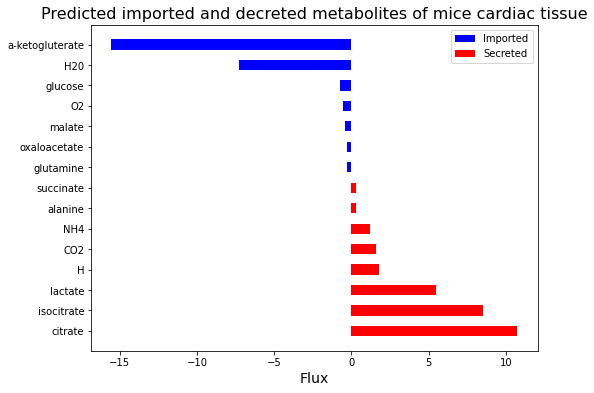

In [14]:
# Sort metabolites and fluxes based on flux values
sorted_uptake_metabolites, sorted_uptake_flux = zip(*sorted(zip(cardiac_uptake_metabolites, cardiac_uptake_flux), key=lambda x: x[1], reverse=True))
sorted_secretion_metabolites, sorted_secretion_flux = zip(*sorted(zip(cardiac_secretion_metabolites, cardiac_secretion_flux), key=lambda x: x[1], reverse=True))

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

# Plot secreted metabolites first
ax.barh(sorted_secretion_metabolites, sorted_secretion_flux, color='red', label='Secreted', height=0.5)

# Plot imported metabolites
ax.barh(sorted_uptake_metabolites, sorted_uptake_flux, color='blue', label='Imported', height=0.5)

# Add labels and title with increased font size
ax.set_xlabel('Flux', fontsize=14)  # Increase font size here
ax.set_title('Predicted imported and decreted metabolites of mice cardiac tissue', fontsize=16)  # Increase font size here

# Get the handles and labels of the legend
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]

# Create the legend with the reordered handles and labels
ax.legend(handles, labels)
# Save the figure as SVG
plt.savefig('mouse_cardiac_prot.svg', format='svg')
# Show plot
plt.show()

In [9]:
print_result(result_Heart[1])

OF value :	 10.728046628462774
Complex I:	1.8078211381794935
Complex II:	-0.7160950609105239
Complex III:	1.08991825613079
Complex IV:	0.544959128065395
Complex V:	0.4087193460490463


In [14]:
print_result(result_BAT[1])

OF value :	 3.8750000000000018
Complex I:	2.25
Complex II:	-2.375
Complex III:	0.75
Complex IV:	0.375
Complex V:	0.0


In [15]:
result_BAT[0].summary()

In [16]:
model_fbat = result_BAT[0]
model_fbat.metabolites.h_m.summary(solution=result_BAT[1])

In [32]:
print_result(result_Heart[1])

OF value :	 10.728046628462774
Complex I:	1.8078211381794935
Complex II:	-0.7160950609105239
Complex III:	1.08991825613079
Complex IV:	0.544959128065395
Complex V:	0.4087193460490463


In [11]:
#ETF fluxes - HEART
print(result_Heart[1].fluxes[143], model.reactions[143].id, model.reactions[143].reaction)
print(result_Heart[1].fluxes[149], model.reactions[149].id, model.reactions[149].reaction)
print(result_Heart[1].fluxes[154], model.reactions[154].id, model.reactions[154].reaction)
print(result_Heart[1].fluxes[159], model.reactions[159].id, model.reactions[159].reaction)
print(result_Heart[1].fluxes[164], model.reactions[164].id, model.reactions[164].reaction)
print(result_Heart[1].fluxes[169], model.reactions[169].id, model.reactions[169].reaction)
print(result_Heart[1].fluxes[212], model.reactions[212].id, model.reactions[212].reaction)
print(result_Heart[1].fluxes[227], model.reactions[227].id, model.reactions[227].reaction)
print(result_Heart[1].fluxes[263], model.reactions[263].id, model.reactions[263].reaction)
print(result_Heart[1].fluxes[282], model.reactions[282].id, model.reactions[282].reaction)

0.0 ACADLC16_mitoMap h2o_m + pmtcoa_m + q10_m --> 3hexdcoa_m + q10h2_m
0.0 r1447_mitoMap ddcacoa_m + q10_m --> dd2coa_m + q10h2_m
0.0 r1451 dcacoa_m + q10_m --> dc2coa_m + q10h2_m
0.0 r1448 occoa_m + q10_m --> HC01415_m + q10h2_m
0.0 r1450 HC01409_m + q10_m --> HC01410_m + q10h2_m
0.0 r1446 btcoa_m + q10_m --> b2coa_m + q10h2_m
0.0 r0655 ivcoa_m + q10_m --> 3mb2coa_m + q10h2_m
0.0 ACCOALm atp_m + coa_m + ppa_m --> amp_m + ppcoa_m + ppi_m
0.0 AMCOXO2_mitoMap amuco_c + h2o_c + h_c + nadh_c --> 2oxoadp_c + nad_c + nh4_c
0.0 PROD2mB_mitoMap pro_L_m + q10_m --> 1pyr5c_m + h_m + q10h2_m


In [12]:
print(result_Heart[1].fluxes[105], model.reactions[105].id, model.reactions[105].reaction)
print(result_Heart[1].fluxes[100], model.reactions[100].id, model.reactions[100].reaction)
print(result_Heart[1].fluxes[180], model.reactions[180].id, model.reactions[180].reaction)
print(result_Heart[1].fluxes[106], model.reactions[106].id, model.reactions[106].reaction)
print(result_Heart[1].fluxes[104], model.reactions[104].id, model.reactions[104].reaction)
print(result_Heart[1].fluxes[163], model.reactions[163].id, model.reactions[163].reaction)
print(result_Heart[1].fluxes[102], model.reactions[102].id, model.reactions[102].reaction)
print(result_Heart[1].fluxes[44], model.reactions[44].id, model.reactions[44].reaction)
print(result_Heart[1].fluxes[66], model.reactions[66].id, model.reactions[66].reaction)
print(result_Heart[1].fluxes[77], model.reactions[77].id, model.reactions[77].reaction)
print(result_Heart[1].fluxes[88], model.reactions[88].id, model.reactions[88].reaction)

2.798203584260894 FUMm fum_m + h2o_m <=> mal_L_m
0.0 ICDHxm icit_m + nad_m --> akg_m + co2_m + nadh_m
0.0 r0760 HC01588_c + h_c + malACP_c --> ACP_c + HC01589_c + co2_c
0.0 MDHm mal_L_m + nad_m <=> h_m + nadh_m + oaa_m
-8.82068968023389 SUCOASm atp_m + coa_m + succ_m <=> adp_m + pi_m + succoa_m
0.0 r0732 HC01406_m + coa_m <=> HC01409_m + accoa_m
8.82068968023389 AKGDm akg_m + coa_m + nad_m --> co2_m + nadh_m + succoa_m
0.0 EX_met_L_e met_L_e <=> 
0.0 EX_tyr_L_e tyr_L_e <=> 
0.7493188010899182 PFK atp_c + f6p_c --> adp_c + fdp_c + h_c
-1.1982223508934873 LDH_L lac_L_c + nad_c <=> h_c + nadh_c + pyr_c


In [38]:
result_Heart[0].metabolites.get_by_id('cit_m').summary(solution=result_Heart[1])
result_Heart[0].metabolites.get_by_id('icit_m').summary(solution=result_Heart[1])
result_Heart[0].metabolites.get_by_id('akg_m').summary(solution=result_Heart[1])
result_Heart[0].metabolites.get_by_id('succoa_m').summary(solution=result_Heart[1])
result_Heart[0].metabolites.get_by_id('succ_m').summary(solution=result_Heart[1])
result_Heart[0].metabolites.get_by_id('fum_m').summary(solution=result_Heart[1])
#result_Heart[0].metabolites.get_by_id('mal_L_m').summary(solution=result_Heart[1])
#result_Heart[0].metabolites.get_by_id('oaa_m').summary(solution=result_Heart[1])
#result_Heart[0].metabolites.get_by_id('pyr_m').summary(solution=result_Heart[1]) #accoa_m
#result_Heart[0].metabolites.get_by_id('accoa_m').summary(solution=result_Heart[1]) #accoa_m
#result_Heart[0].metabolites.get_by_id('q10h2_m').summary(solution=result_Heart[1]) #pro_L_m
#result_Heart[0].metabolites.get_by_id('pro_L_m').summary(solution=result_Heart[1]) #pro_L_m
#result_Heart[0].metabolites.get_by_id('glu_L_m').summary(solution=result_Heart[1]) #pro_L_m

In [33]:
BAT_uptake_metabolites = ['acetoacetate','a-ketogluterate','alanine', 'aspartate', 'butanoic acid','citrate', 'cysteine','fumarate', 'glucose', 'H', 'malate', 'O2','sulfite']
BAT_uptake_flux = [-4.655, -13.25, -0.5, -0.875, -4.01, -17.12, -5.5, -7.47, -42.37, -2.78, -0.3773, -5.5]

BAT_secretion_metabolites = ['CO2', 'hexadecanoic acid', 'isocitrate', 'NH4', 'propanoate', 'succinate', 'thiosulfate']
BAT_secretion_flux = [45.7, 4.01, 12.88, 6.875, 0.4498, 19.43, 5.5 ]     

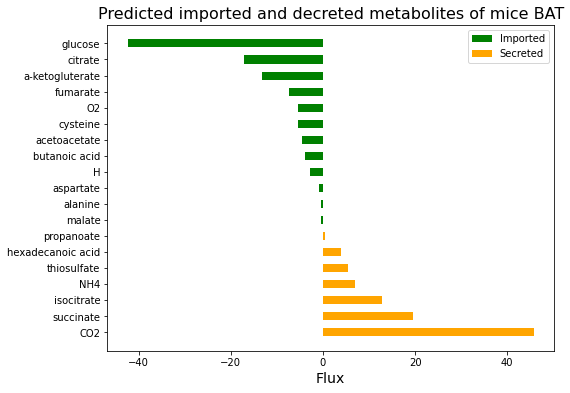

In [35]:
# Sort metabolites and fluxes based on flux values
sorted_uptake_metabolites, sorted_uptake_flux = zip(*sorted(zip(BAT_uptake_metabolites, BAT_uptake_flux), key=lambda x: x[1], reverse=True))
sorted_secretion_metabolites, sorted_secretion_flux = zip(*sorted(zip(BAT_secretion_metabolites, BAT_secretion_flux), key=lambda x: x[1], reverse=True))

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the size as needed

# Plot secreted metabolites first
ax.barh(sorted_secretion_metabolites, sorted_secretion_flux, color='orange', label='Secreted', height=0.5)

# Plot imported metabolites
ax.barh(sorted_uptake_metabolites, sorted_uptake_flux, color='green', label='Imported', height=0.5)

# Add labels and title with increased font size
ax.set_xlabel('Flux', fontsize=14)  # Increase font size here
ax.set_title('Predicted imported and decreted metabolites of mice BAT', fontsize=16)  # Increase font size here

# Get the handles and labels of the legend
handles, labels = ax.get_legend_handles_labels()

# Reorder the handles and labels
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]

# Create the legend with the reordered handles and labels
ax.legend(handles, labels)

# Save the figure as SVG
plt.savefig('mouse_BAT_prot.svg', format='svg')
# Show plot
plt.show()

In [18]:
#run to indentify the complete solution with all reactions and fluxes
result_BAT[1]

<Solution 888.188 at 0x7f3e1b9de150>

In [23]:
for i in result_BAT[1]:
    print (i)

0.0
0.0
-4.65512500000006
-13.25000000000024
0.0
-0.5
0.0
0.0
0.0
-0.8750000000000001
0.0
0.0
3.8750000000000018
-4.0100416666666865
0.0
-17.125
0.0
0.0
45.699791666667046
0.0
0.0
-5.500000000000002
0.0
0.0
0.0
-7.469874999999945
0.0
0.0
0.0
0.0
0.0
-42.36945833333356
0.0
0.0
0.0
4.0100416666666865
0.0
12.875
0.0
0.0
0.0
0.0
-2.7801250000000497
0.0
0.0
-1.7763568394002505e-15
0.0
6.875000000000002
0.0
-0.37725000000000003
0.0
0.0
0.0
0.0
0.0
0.0
0.4497916666668029
0.0
0.0
0.0
-5.500000000000002
19.425208333333437
0.0
0.0
0.0
5.500000000000002
0.0
0.0
0.0
0.0
3.8750000000000018
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
13.875000000000002
0.0
17.125
0.0
4.25
17.500000000000238
0.0
-12.395083333333375
19.949791666666805
0.0
2.25
-2.375
0.75
0.375
0.0
0.0
0.0
7.875
0.0
0.5
0.0
0.0
3.6875000000001172
4.0100416666666865
0.0
0.0
0.0
-14.85491666666686
0.0
0.0
0.0
0.0
0.0
0.0
-13.25000000000024
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.